# Rebinning and How to Use Dask

## Fundamentals of Dask

In this session we are going to use the example of rebinning VISP data to discuss how the Dask array backing the `Dataset` object works.
Dask is a Python package for out-of-memory and parallel computation in Python, it provides an array-like object where data is only loaded and processed on demand.
`Dataset` uses Dask to track the data arrays, which it stores in the `Dataset.data` attribute.

To demonstrate this let's load our VISP dataset from yesterday, and slice it to a more manageable size again.

In [1]:
import dkist
import dkist.net
import matplotlib.pyplot as plt

ds = dkist.Dataset.from_directory("~/sunpy/data/VISP/AGLKO")
ds = ds[0, 520:720, :, 1000:1500]

This Dask object behaves in many ways just like a numpy array.
For instance, it can indexed and sliced in the same way.

In [6]:
ds.data[:, :, :200]

dask.array<getitem, shape=(200, 976, 200), dtype=float64, chunksize=(1, 976, 200), chunktype=numpy.ndarray>

And it has many of the same methods for calculating useful properties of the data, such as `min()`, `max()`, `sum()`, etc.
These are in fact just wrappers around the numpy functions themselves, so they behave in the same way.
For example, to find the sum over the spatial dimensions of our cropped data to make a spectrum, we could do:

In [7]:
ds.data.sum(axis=(0,2))

dask.array<sum-aggregate, shape=(976,), dtype=float64, chunksize=(976,), chunktype=numpy.ndarray>

What you will notice when you call these functions that they don't return a number as you would expect.
Instead they give us a Dask array which represents the result of that calculation.
This is because Dask delays the actual calculation of the value until you explicitly tell it to do it using the `compute()` method.

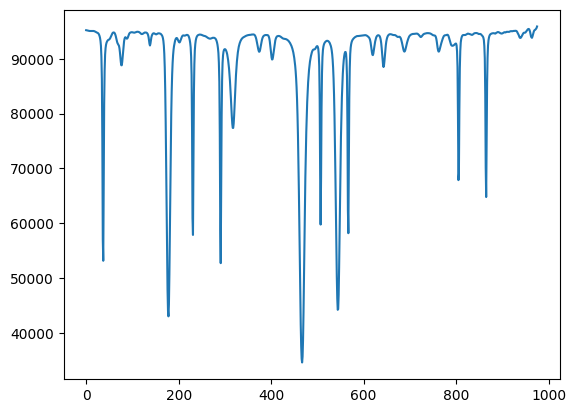

In [8]:
spectrum = ds.data.sum(axis=(0,2)).compute()
plt.plot(spectrum)

A benefit of this is that since the operations returns us another Dask array, we can do more calculations with that, and those are also delayed.
This means that you can string together any number of calculations and only perform the costly step of getting the actual answer once.
So if we want to find the location of the lowest value in this spectrum, we can do

In [16]:
spectrum = ds.data.sum(axis=(0,2))
wl_idx = spectrum.argmin()
wl = ds[0, :, 0].wcs.pixel_to_world(wl_idx.compute())
wl

<SpectralCoord 631.0014064 nm>

When performing these operations, Dask breaks up the array into chunks, and operations will generally be faster and use less memory when they require fewer chunks. 
In the case of a `Dataset`, these chunks are aligned with the files, so each chunk essentially consists of the array stored in one FITS file.
In the future we may break down a FITS file into more chunks, so the whole array does not always have to be read.

## Rebinning with `NDCube`

In [18]:
import dkist
import matplotlib.pyplot as plt

ds = dkist.Dataset.from_directory("~/sunpy/data/VISP/AGLKO")

We are going to use the {obj}`ndcube.NDCube.rebin` method:

In [19]:
help(ds.rebin)

Help on method rebin in module ndcube.ndcube:

rebin(bin_shape, operation=<function mean at 0x7f86f0d00ae0>, operation_ignores_mask=False, handle_mask=<function all at 0x7f86f15f77e0>, propagate_uncertainties=False, new_unit=None, **kwargs) method of dkist.dataset.dataset.Dataset instance
    Downsample array by combining contiguous pixels into bins.
    
    Values in bins are determined by applying a function to the pixel values within it.
    The number of pixels in each bin in each dimension is given by the bin_shape input.
    This must be an integer fraction of the cube's array size in each dimension.
    If the NDCube instance has uncertainties attached, they are propagated
    depending on binning method chosen.
    
    Parameters
    ----------
    bin_shape : array-like
        The number of pixels in a bin in each dimension.
        Must be the same length as number of dimensions in data.
        Each element must be in int. If they are not they will be rounded
        to t

This rebin method, can reduce the resolution of a dataset, *by integer numbers of pixels*.

So if we wanted to combine 7 pixels along the slit dimension together we can do this:

In [22]:
ds.rebin((1, 1, 1, 7))

This Dataset has 4 pixel and 5 world dimensions

dask.array<mean_agg-aggregate, shape=(4, 1000, 976, 365), dtype=float64, chunksize=(1, 1, 976, 365), chunktype=numpy.ndarray>

Pixel Dim  Axis Name                Data size  Bounds
        0  polarization state               4  None
        1  raster scan step number       1000  None
        2  dispersion axis                976  None
        3  spatial along slit             365  None

World Dim  Axis Name                  Physical Type                   Units
        0  stokes                     phys.polarization.stokes        unknown
        1  time                       time                            s
        2  helioprojective longitude  custom:pos.helioprojective.lon  arcsec
        3  wavelength                 em.wl                           nm
        4  helioprojective latitude   custom:pos.helioprojective.lat  arcsec

Correlation between pixel and world axes:

               Pixel Dim
World Dim    0    1    2    3
        0

```{note}
Because we are using Dask, this hasn't actually done any computation yet, but is has reduced the size of the dask array.
```

Let's compare two spectra, one from the rebinned dataset and one from the original:

In [23]:
ds_I = ds[0]
ds_I_rebinned = ds_I.rebin((1,1,7))

<WCSAxes: ylabel='Data [ct]'>

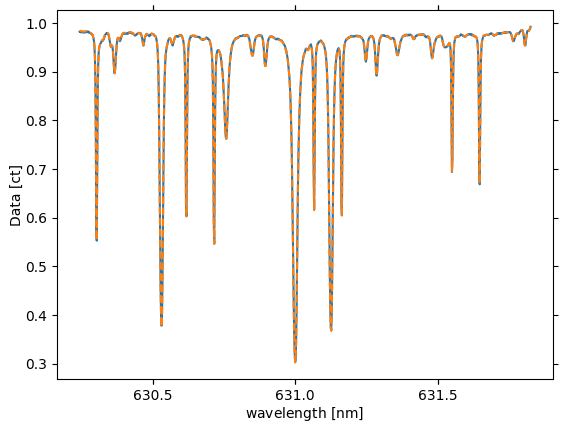

In [24]:
plt.figure()
ax = ds_I[500, :, 1000].plot()
ds_I_rebinned[500, :, int(1000/7)].plot(axes=ax, linestyle="--")

As one final example of rebin, let's rebin in both the rastering dimension and the slit.
Let's rebin to bins of 10x10 pixels, to do this we will need to make the slit axis divisible by 10, so we crop it down by 5 pixels.

In [25]:
ds_r10 = ds[0, :, :, :-5].rebin((10, 1, 10))

/home/stuart/.virtualenvs/instructor-user-tools-workshop/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  if await self.run_code(code, result, async_=asy):


In [27]:
import numpy as np

In [29]:
ds_avg = ds_I.rebin(
    (ds_I.data.shape[0], 1, ds_I.data.shape[2]),
    operation=np.sum
)
ds_avg = ds_avg[0, :, 0]
ds_avg

This Dataset has 1 pixel and 1 world dimensions

dask.array<getitem, shape=(976,), dtype=float64, chunksize=(976,), chunktype=numpy.ndarray>

Pixel Dim  Axis Name        Data size  Bounds
        0  dispersion axis        976  None

World Dim  Axis Name   Physical Type  Units
        0  wavelength  em.wl          nm

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0
        0  yes

<WCSAxes: ylabel='Data [ct]'>

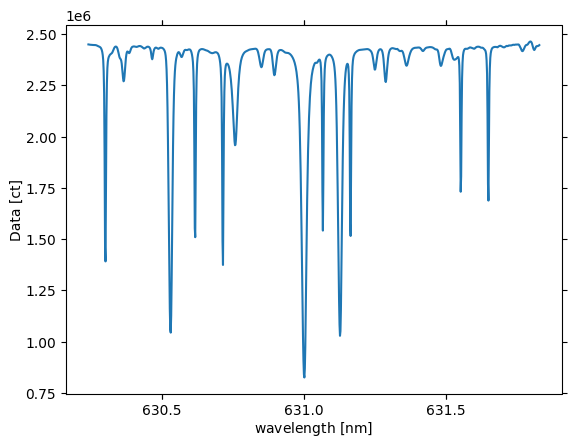

In [30]:
ds_avg.plot()

## Rebinning in Parallel

By default dask will parallelise operations as much as is possible, over the available cores in your machine.
The Dask project also supports paralleising over the distributed compute such as HPC or cloud computing.
For this next section we are going to use this `distributed` package as a way of visualising the paralleisation.

If you want to follow along with this bit you will need to install these packages, if you want to just watch that's also fine.

`conda install distributed bokeh`

In [31]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.33 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41975,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.33 GiB
Comm: tcp://127.0.0.1:37961,Total threads: 2
Dashboard: http://127.0.0.1:38095/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:41977,


In [32]:
rebinned_ds = ds[0, ..., :-5].rebin((10, 1, 10))

/home/stuart/.virtualenvs/instructor-user-tools-workshop/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  if await self.run_code(code, result, async_=asy):


In [33]:
computed_data = rebinned_ds.data.compute()

In [34]:
rebinned_ds._data = computed_data

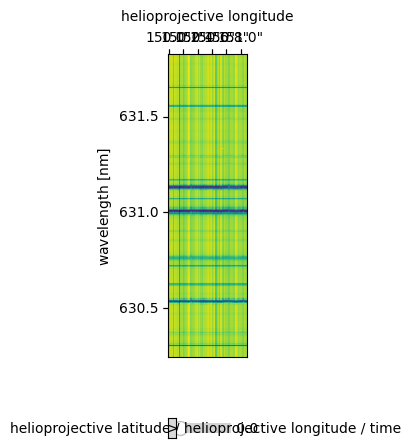

In [35]:
rebinned_ds.plot()

In [42]:
stepped_spectra = ds.data[0, 0, ::5, 0]
stepped_spectra

dask.array<getitem, shape=(196,), dtype=float64, chunksize=(196,), chunktype=numpy.ndarray>

In [45]:
waves = ds.axis_world_coords("em.wl")[0]
waves

<SpectralCoord [630.24247765, 630.24410276, 630.24572788, 630.24735299, 630.24897811,
   630.25060322, 630.25222834, 630.25385345, 630.25547857, 630.25710368,
   630.2587288 , 630.26035391, 630.26197903, 630.26360414, 630.26522926,
   630.26685437, 630.26847949, 630.2701046 , 630.27172972, 630.27335483,
   630.27497995, 630.27660506, 630.27823018, 630.27985529, 630.28148041,
   630.28310552, 630.28473064, 630.28635575, 630.28798087, 630.28960599,
   630.2912311 , 630.29285622, 630.29448133, 630.29610645, 630.29773156,
   630.29935668, 630.30098179, 630.30260691, 630.30423202, 630.30585714,
   630.30748225, 630.30910737, 630.31073248, 630.3123576 , 630.31398271,
   630.31560783, 630.31723294, 630.31885806, 630.32048317, 630.32210829,
   630.3237334 , 630.32535852, 630.32698363, 630.32860875, 630.33023386,
   630.33185898, 630.33348409, 630.33510921, 630.33673432, 630.33835944,
   630.33998455, 630.34160967, 630.34323478, 630.3448599 , 630.34648501,
   630.34811013, 630.34973524, 630.351

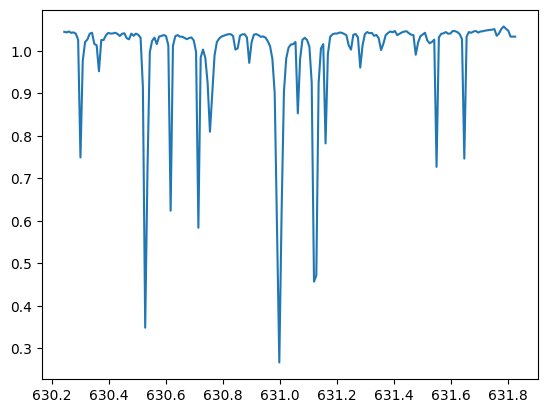

In [46]:
plt.plot(waves[::5], stepped_spectra)